In [2]:

import dgl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, gen_q_dict_mis_sharpe_reward, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import annualized_sharpe_ratio, annualized_sortino_ratio
from utils_distance_correlation import dcor

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [3]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


## Read in Data

In [4]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

sp500_hist = sp500_hist.loc['2015-01-01':,]
sp500_hist.dropna(axis=1, inplace=True)


print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (2014, 478)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.823849,51.079903,146.459579,24.565695,46.113235,79.364059,38.241337,19.496668,77.119682,72.339996,...,129.637009,28.097225,63.720268,48.605167,34.251171,44.513111,102.393478,77.430000,23.814734,40.952682
2015-01-05,37.115143,51.051491,144.529114,23.873646,45.245419,78.688522,38.249859,19.379999,75.817574,71.980003,...,127.430634,27.778292,61.976727,48.268211,32.119461,43.608700,106.213135,76.339996,22.922415,40.706844
2015-01-06,36.536957,50.255581,144.427490,23.875891,45.021481,79.118393,37.815487,19.423332,75.270683,70.529999,...,124.712379,27.926092,61.647266,47.669205,31.930571,43.073429,105.312767,75.790001,22.046934,40.309696
2015-01-07,37.021870,50.227150,147.531052,24.210676,46.841084,80.697617,38.122097,19.536667,76.850571,71.110001,...,128.375000,28.167236,62.271912,48.904675,32.182419,44.500801,107.931953,77.720001,22.257389,41.141811
2015-01-08,38.131599,50.843037,148.824203,25.140913,47.330963,80.881851,38.905670,19.876667,78.022469,72.919998,...,129.919373,28.493950,63.308403,50.112080,32.425278,45.276012,109.077820,79.379997,22.568857,41.775345


### S&P500 as Benchmark

In [5]:
gspc = yf.download(
    tickers="^GSPC", 
    start=sp500_hist.index[0].strftime(format="%Y-%m-%d"), 
    end=sp500_hist.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc = gspc.loc['2015-01-01':,]
gspc

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02    2058.199951
2015-01-05    2020.579956
2015-01-06    2002.609985
2015-01-07    2025.900024
2015-01-08    2062.139893
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 2013, dtype: float64

In [6]:
TRAIN_START_DATE, TRAIN_END_DATE = "2015-01-01", "2020-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2021-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2023-01-01"

df_train = sp500_hist.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = sp500_hist.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = sp500_hist.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (1258, 478)
Validation shape: (253, 478)
Test shape: (503, 478)


### Build correlation matrix

In [ ]:
def run_pipeline(df_corr:pd.DataFrame, threshold:float=0.5):
    param_dict = {}
    stock_names = df_corr.columns.values

    # Check if df_corr has correct shape
    assert df_corr.shape[0] == df_corr.shape[1]
    param_dict['df_corr_median'] = df_corr.quantile(0.5).mean()


    # Build NetworkX graph
    nx_graph = build_nx_graph(
        df_corr=df_corr,
        threshold=threshold
    )

    assert (df_corr.where(df_corr >= threshold).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

    param_dict['degrees'] = [degree for (node, degree) in nx_graph.degree()]
    param_dict['avg_degree'] = sum(param_dict['degrees']) / len(param_dict['degrees'])


In [ ]:
METHOD = 'pct'
CORR_METHOD = 'pearson'

if METHOD == 'standard':
    df_corr = df_train.corr(method=CORR_METHOD).abs()
elif METHOD == 'pct':
    df_train_pct = df_train.pct_change()
    df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
elif METHOD == 'pct_yearly':
    df_train_pct = df_train.pct_change()
    df_train_pct = df_train_pct.groupby(df_train_pct.index.year).sum()
    df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
elif METHOD == 'drawdown':
    df_mdd = df_train.apply(lambda x: drawdown(x))
    df_corr = df_mdd.corr(method=CORR_METHOD).abs()
else:
    raise KeyError("METHOD must be either 'standard', 'pct' or 'pct_yearly'.")

# df_train_pct = df_train.pct_change()
# df_corr = df_train_pct.corr(method=dcor)

df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.377490,0.278648,0.426086,0.395127,0.395715,0.436315,0.451611,0.542658,0.528511,...,0.446320,0.321330,0.521572,0.543987,0.466992,0.454588,0.496955,0.455587,0.453823,0.421125
AAL,0.377490,1.000000,0.222802,0.281358,0.230219,0.247036,0.245888,0.358579,0.280142,0.336947,...,0.362016,0.194477,0.258093,0.328868,0.261922,0.335371,0.299906,0.262792,0.350474,0.289608
AAP,0.278648,0.222802,1.000000,0.212792,0.210450,0.208975,0.254871,0.238312,0.253933,0.230069,...,0.208382,0.209497,0.254363,0.268908,0.256026,0.307996,0.250243,0.257291,0.249090,0.205259
AAPL,0.426086,0.281358,0.212792,1.000000,0.211185,0.264085,0.306288,0.313199,0.386224,0.406557,...,0.383202,0.212159,0.363080,0.346439,0.294178,0.386315,0.356456,0.351841,0.346793,0.298356
ABBV,0.395127,0.230219,0.210450,0.211185,1.000000,0.357279,0.444119,0.201294,0.332795,0.317001,...,0.224578,0.163817,0.307661,0.325147,0.313689,0.237877,0.392381,0.239003,0.290284,0.390879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.454588,0.335371,0.307996,0.386315,0.237877,0.286077,0.351322,0.378501,0.414654,0.432484,...,0.381711,0.306293,0.414353,0.384837,0.351290,1.000000,0.359590,0.340433,0.380528,0.292869
ZBH,0.496955,0.299906,0.250243,0.356456,0.392381,0.367133,0.475346,0.359583,0.422443,0.401029,...,0.345810,0.289338,0.443852,0.516767,0.355353,0.359590,1.000000,0.342208,0.387854,0.350850
ZBRA,0.455587,0.262792,0.257291,0.351841,0.239003,0.269297,0.311975,0.318131,0.402669,0.389423,...,0.349209,0.186168,0.393325,0.296350,0.329922,0.340433,0.342208,1.000000,0.319799,0.293736
ZION,0.453823,0.350474,0.249090,0.346793,0.290284,0.246266,0.279019,0.457824,0.371702,0.372629,...,0.418244,0.175014,0.419720,0.409550,0.415076,0.380528,0.387854,0.319799,1.000000,0.294470


In [ ]:
df_corr.quantile(0.5).mean()

0.359697136322241

In [ ]:
STOCK_NAMES = df_corr.columns.values

## Build Graph

In [ ]:
THRESHOLD = 0.5

nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=THRESHOLD
)

# assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'
assert (df_corr.where(df_corr >= THRESHOLD).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

In [ ]:
len(nx_graph.edges)

11750

In [ ]:
df_train_sharpe.mean()

A       0.838191
AAL     0.626797
AAP     0.769793
AAPL    1.115527
ABBV    1.027418
          ...   
YUM     0.842293
ZBH     0.547688
ZBRA    0.844125
ZION    0.484094
ZTS     0.953059
Length: 484, dtype: float64

### Plot degree distribution

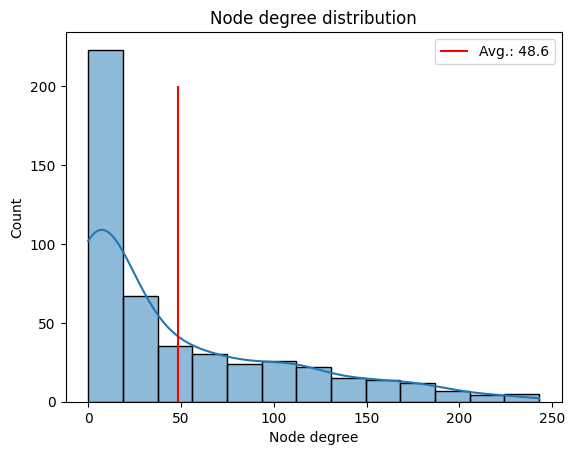

In [ ]:
degrees = [degree for (node, degree) in nx_graph.degree()]
avg_degree = sum(degrees) / len(degrees)

sns.histplot(degrees, kde=True)
plt.vlines(avg_degree, ymin=0, ymax=200, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
plt.title("Node degree distribution")
plt.xlabel("Node degree")
plt.legend()
plt.show()

### Build Q matrix

In [ ]:
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    # gen_q_dict_mis(nx_graph),
    gen_q_dict_mis_sharpe_reward(nx_graph, rewards=df_train_sharpe.mean().values*-1),
    torch_dtype=TORCH_DTYPE, 
    torch_device=TORCH_DEVICE
    )

In [ ]:
q_torch

tensor([[-0.8382,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.6268,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.7698,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.8441,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.4841,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.9531]])

### Visualize graph

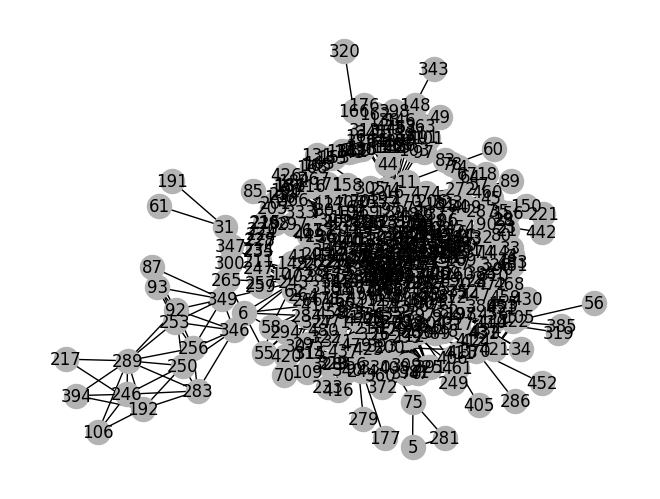

In [ ]:
if len(nx_graph.nodes) < 500:
    pos = nx.kamada_kawai_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
# nx_graph_labelled_vis = nx.relabel_nodes(nx_graph, lambda x: STOCK_NAMES[x])
# pos_labelled_vis = nx.kamada_kawai_layout(nx_graph_labelled_vis)
# nx.draw(nx_graph_labelled_vis, pos_labelled_vis, with_labels=True, node_color=[[.7, .7, .7]])

## Set up GNN

In [ ]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 30000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [ ]:
n = len(nx_graph.nodes)

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [ ]:
print('Running GNN...')
gnn_start = time()

net, embed, optimizer = get_gnn(
    n_nodes=n, 
    params=params, 
    model_type=params["model"], 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE)   
    
net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
    q_torch=q_torch, 
    dgl_graph=graph_dgl, 
    net=net, 
    embed=embed, 
    optimizer=optimizer, 
    number_epochs=params['number_epochs'],
    tol=params['tolerance'], 
    patience=params['patience'], 
    prob_threshold=params['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 7940.57421875
Epoch: 1000, Loss: -20.805618286132812
Epoch: 2000, Loss: -39.45069122314453
Epoch: 3000, Loss: -53.85559844970703
Epoch: 4000, Loss: -59.879276275634766
Epoch: 5000, Loss: -66.91564178466797
Epoch: 6000, Loss: -71.74436950683594
Epoch: 7000, Loss: -76.97494506835938
Epoch: 8000, Loss: -84.16534423828125
Epoch: 9000, Loss: -86.740478515625
Epoch: 10000, Loss: -97.82341766357422
Epoch: 11000, Loss: -104.45922088623047
Epoch: 12000, Loss: -114.59717559814453
Epoch: 13000, Loss: -122.32860565185547
Epoch: 14000, Loss: -122.02433013916016
Epoch: 15000, Loss: -123.77710723876953
Epoch: 16000, Loss: -124.75725555419922
Epoch: 17000, Loss: -124.35131072998047
Epoch: 18000, Loss: -124.90003204345703
Epoch: 19000, Loss: -124.37654113769531
Epoch: 20000, Loss: -125.03435516357422
Epoch: 21000, Loss: -124.9698257446289
Epoch: 22000, Loss: -124.19671630859375
Epoch: 23000, Loss: -125.24564361572266
Epoch: 24000, Loss: -125.3094253540039
Epoch: 25000, Lo

## Post-process GNN Results

In [ ]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis_gnn} with {number_violations_gnn} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 177 with 0 violations
Took 354.332s, model training took 354.143s


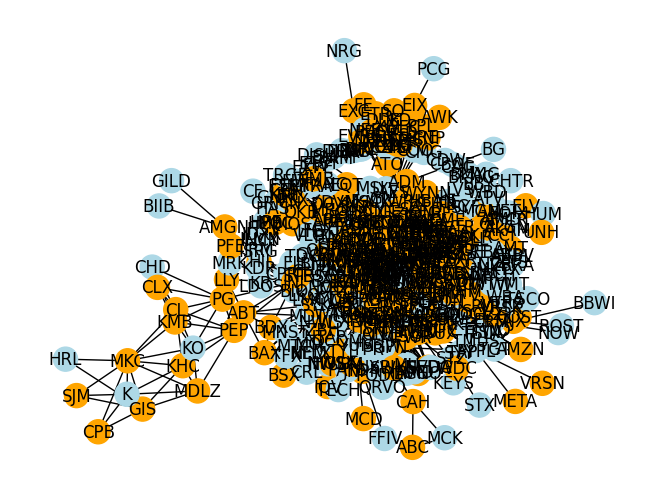

In [ ]:
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [ ]:
gnn_mis_set = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

## Compare against traditional solver

In [ ]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=484).
Calculating violations...
Independence number found by nx solver is 180 with 0 violations.
MIS solver took 10.333s


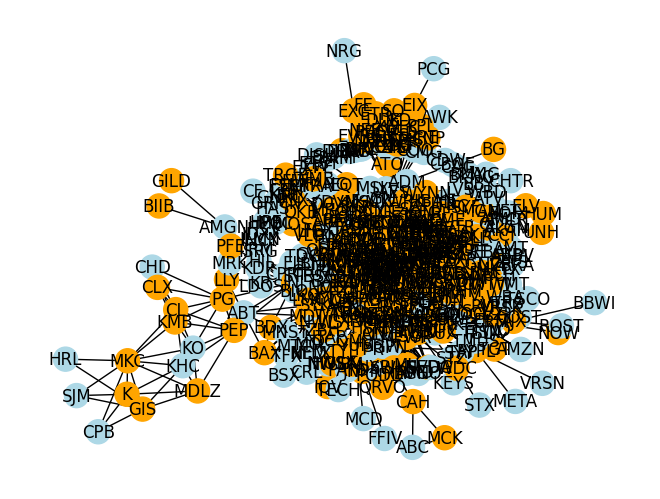

In [ ]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [ ]:
solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

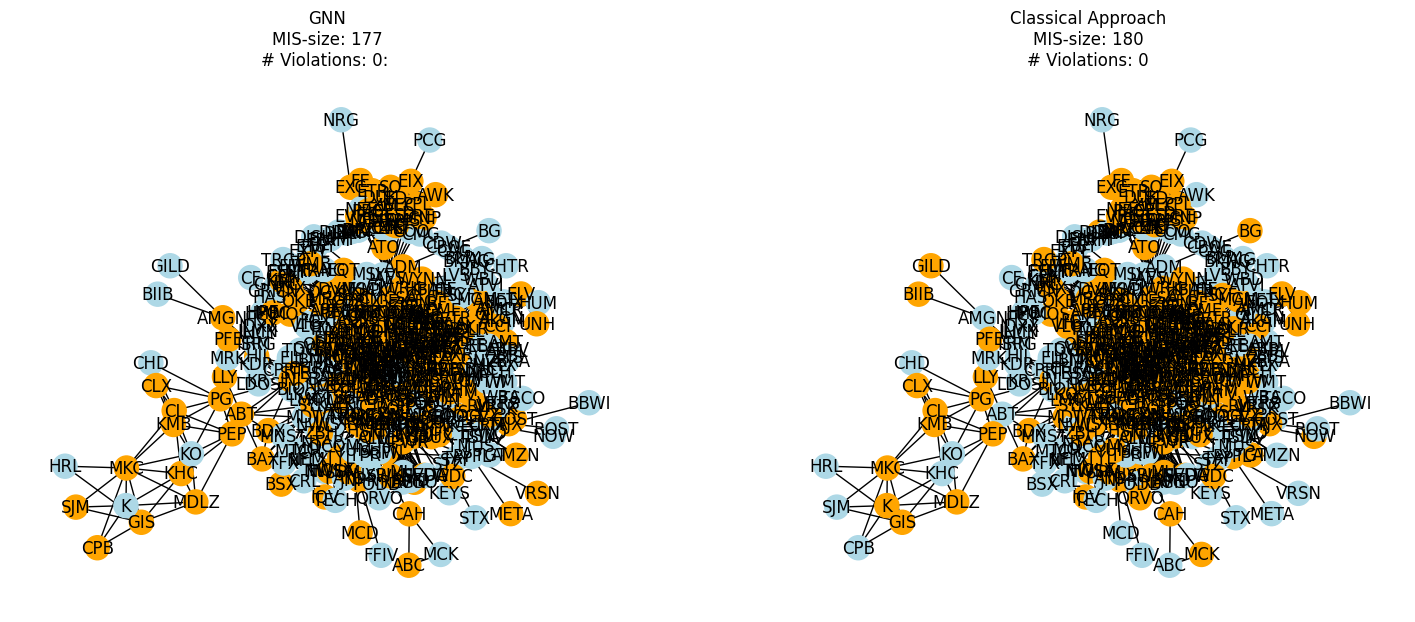

In [ ]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# GNN
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax0)
ax0.set_title(f"GNN\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

In [ ]:
df_mis = pd.concat([
    pd.DataFrame(
        data={'gnn': gnn_mis_set},
        index=gnn_mis_set
    ),
    pd.DataFrame(
        data={'solver': solver_mis_set},
        index=solver_mis_set
    )
],
axis=1)

df_mis

,gnn,solver
AAPL,AAPL,AAPL
ABBV,ABBV,ABBV
AIG,AIG,AIG
AKAM,AKAM,AKAM
ALGN,ALGN,ALGN
...,...,...
MPC,NaN,MPC
SBUX,NaN,SBUX
SJM,NaN,SJM
STE,NaN,STE


In [ ]:
# intersection
df_intersec = df_mis.dropna(axis=0)
print(f"Length: {len(df_intersec)}")
df_intersec

Length: 141


,gnn,solver
AAPL,AAPL,AAPL
ABBV,ABBV,ABBV
AIG,AIG,AIG
AKAM,AKAM,AKAM
ALGN,ALGN,ALGN
...,...,...
WBA,WBA,WBA
WBD,WBD,WBD
WMT,WMT,WMT
ZBRA,ZBRA,ZBRA


In [ ]:
# Not intersecting
df_non_intersec = df_mis.drop(index=df_intersec.index)
print(f"Length: {len(df_non_intersec)}")
df_non_intersec

Length: 75


,gnn,solver
ALK,ALK,NaN
AZO,AZO,NaN
BALL,BALL,NaN
BG,BG,NaN
BIIB,BIIB,NaN
...,...,...
MPC,NaN,MPC
SBUX,NaN,SBUX
SJM,NaN,SJM
STE,NaN,STE


## Backtest

In [ ]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

## Training

In [ ]:
def portfolio_return(df, assets):
    """" """
    df_returns = df.pct_change()
    df_returns.dropna(axis=0, inplace=True)

    # assert df_returns.shape[0] + 1 == df.shape[0]
    # assert df_returns.shape[1] == df.shape[1]

    returns = df_returns.loc[:,assets].mean(axis=1)

    return returns, returns.cumsum()


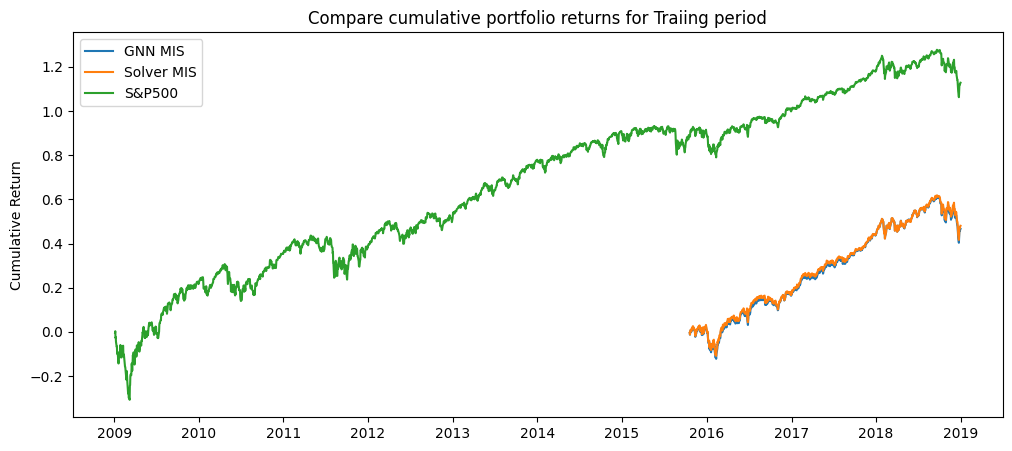

In [ ]:
# GNN MIS Portfolio
gnn_mis_returns_train, gnn_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_train, solver_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_train = gspc_train.pct_change()
gspc_returns_cum_train = gspc_returns_train.cumsum()
# gspc_returns_cum_val_1 = ((gspc_val.pct_change() +1 ).cumprod()) -1


# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_train, label="GNN MIS")
plt.plot(solver_mis_returns_cum_train, label="Solver MIS")
plt.plot(gspc_returns_cum_train, label="S&P500")
# plt.plot(gspc_returns_cum_val_1, label="S&P500_1")


plt.title("Compare cumulative portfolio returns for Traiing period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [ ]:
df_val

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,63.738407,31.963156,146.872147,38.047050,72.144707,69.589737,64.570114,26.190001,132.098801,224.570007,...,100.250526,42.937187,55.378777,36.345924,63.187229,84.758568,96.177956,156.240005,36.702114,82.211685
2019-01-03,61.390285,29.581665,151.457260,34.257275,69.767639,68.580238,61.522812,25.780001,127.588646,215.699997,...,99.280678,42.768002,54.528500,36.365101,61.021133,82.626602,94.438339,146.880005,36.499088,79.370102
2019-01-04,63.515232,31.530161,147.699860,35.719696,72.015343,69.374741,63.278732,26.389999,132.549805,226.190002,...,103.284920,43.186508,56.538956,37.420269,63.595757,84.777084,97.663696,152.970001,37.620098,82.484184
2019-01-07,64.863930,32.425678,149.866852,35.640194,73.066429,69.870148,64.226395,26.330000,133.010193,229.259995,...,105.119026,42.999519,56.832962,38.091747,62.655209,84.684387,97.701317,155.289993,37.770161,82.980484
2019-01-08,65.814827,31.904114,148.825241,36.319607,73.406006,70.617912,63.455269,26.430000,136.374023,232.679993,...,108.412682,43.498161,57.246174,37.832748,63.244251,84.517555,95.510307,156.330002,38.114407,84.216385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,83.296394,29.072563,149.564804,69.517082,76.751320,81.385277,82.433838,42.009998,201.337585,329.640015,...,138.279648,57.497868,58.305912,55.164673,75.659081,94.552063,142.686523,254.330002,46.753819,130.175430
2019-12-26,83.442856,29.560759,148.353897,70.896339,76.734230,81.032761,82.433838,42.180000,201.756226,331.200012,...,139.767166,57.433834,58.397507,54.604424,75.620583,95.927986,142.373917,254.419998,46.871769,130.283127
2019-12-27,83.413574,28.335287,147.496948,70.869431,76.196068,80.899368,82.547173,42.560001,201.917984,330.790009,...,138.646561,57.735687,58.197655,54.903870,75.851494,96.031639,142.099243,256.000000,46.726597,130.498566


### Validation

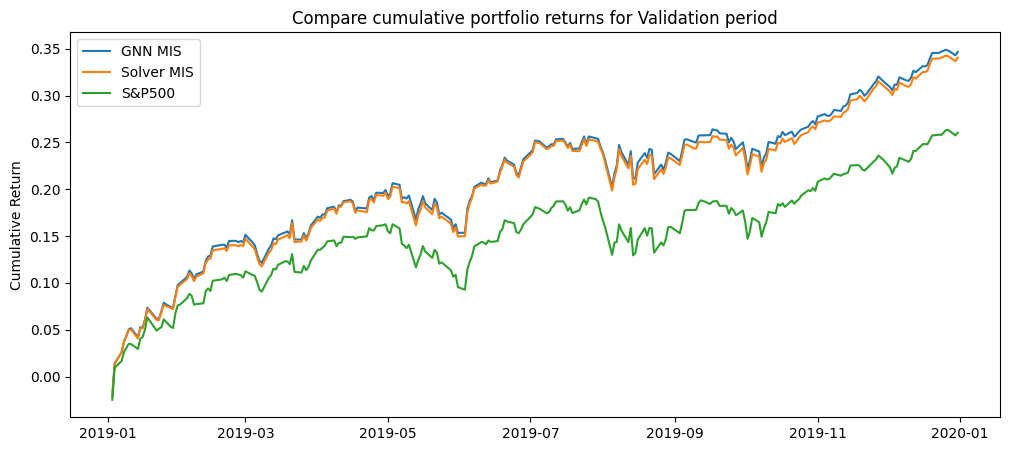

In [ ]:
# GNN MIS Portfolio
gnn_mis_returns_val, gnn_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_val, solver_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_val = gspc_val.pct_change()
gspc_returns_cum_val = gspc_returns_val.cumsum()
# gspc_returns_cum_val_1 = ((gspc_val.pct_change() +1 ).cumprod()) -1


# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_val, label="GNN MIS")
plt.plot(solver_mis_returns_cum_val, label="Solver MIS")
plt.plot(gspc_returns_cum_val, label="S&P500")
# plt.plot(gspc_returns_cum_val_1, label="S&P500_1")


plt.title("Compare cumulative portfolio returns for Validation period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

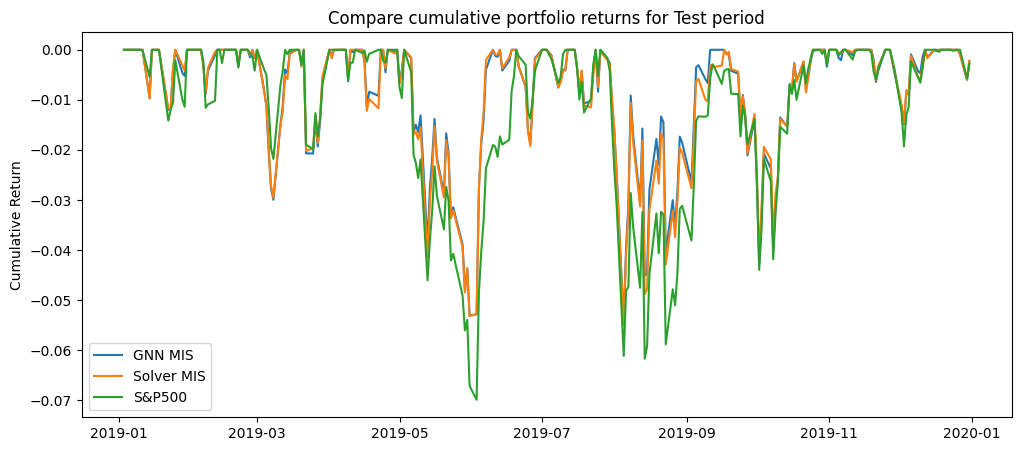

In [ ]:
gnn_mis_mdd_val = drawdown_pct(gnn_mis_returns_cum_val)
solver_mis_mdd_val = drawdown_pct(solver_mis_returns_cum_val)
gspc_mdd_val = drawdown_pct(gspc_returns_cum_val)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_val, label="GNN MIS")
plt.plot(solver_mis_mdd_val, label="Solver MIS")
plt.plot(gspc_mdd_val, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [ ]:
# Sharpe Ratio
gnn_mis_sharpe_ratio = sharpe_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_sharpe_ratio = sharpe_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_sharpe_ratio = sharpe_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS sharpe ratio: {gnn_mis_sharpe_ratio:.2f}")
print(f"Solver MIS sharpe ratio: {solver_mis_sharpe_ratio:.2f}")
print(f"S&P500 sharpe ratio: {gspc_sharpe_ratio:.2f}\n")

# Sortino Ratio
gnn_mis_sortino_ratio = sortino_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_sortino_ratio = sortino_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_sortino_ratio = sortino_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS sortino ratio: {gnn_mis_sortino_ratio:.2f}")
print(f"Solver MIS sortino ratio: {solver_mis_sortino_ratio:.2f}")
print(f"S&P500 sortino ratio: {gspc_sortino_ratio:.2f}\n")

# Maximal drawdown
gnn_mis_mdd = max_drawdown(return_series=gnn_mis_returns_val)
solver_mis_mdd = max_drawdown(return_series=solver_mis_returns_val)
gspc_mdd = max_drawdown(return_series=gspc_returns_val)

print(f"GNN MIS MDD: {gnn_mis_mdd:.2f}")
print(f"Solver MIS MDD: {solver_mis_mdd:.2f}")
print(f"S&P500 MDD: {gspc_mdd:.2f}\n")

# Calmar ratio
gnn_mis_calmar_ratio = calmar_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_calmar_ratio = calmar_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_calmar_ratio = calmar_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS calmar ratio: {gnn_mis_calmar_ratio:.2f}")
print(f"Solver MIS calmar ratio: {solver_mis_calmar_ratio:.2f}")
print(f"S&P500 calmar ratio: {gspc_calmar_ratio:.2f}")


GNN MIS sharpe ratio: 2.61
Solver MIS sharpe ratio: 2.59
S&P500 sharpe ratio: 2.01

GNN MIS sortino ratio: 3.41
Solver MIS sortino ratio: 3.33
S&P500 sortino ratio: 2.49

GNN MIS MDD: -0.05
Solver MIS MDD: -0.05
S&P500 MDD: -0.07

GNN MIS calmar ratio: -6.30
Solver MIS calmar ratio: -6.14
S&P500 calmar ratio: -3.68


In [ ]:
pd.DataFrame(
    data={
        "sharpe_gnn": [gnn_mis_sharpe_ratio],
        "sharpe_solver": [solver_mis_sharpe_ratio],
        "sharpe_SP500": [gspc_sharpe_ratio],
    },
    index=[2019]
)

,sharpe_gnn,sharpe_solver,sharpe_SP500
2019,2.612856,2.587509,2.011341


### Test

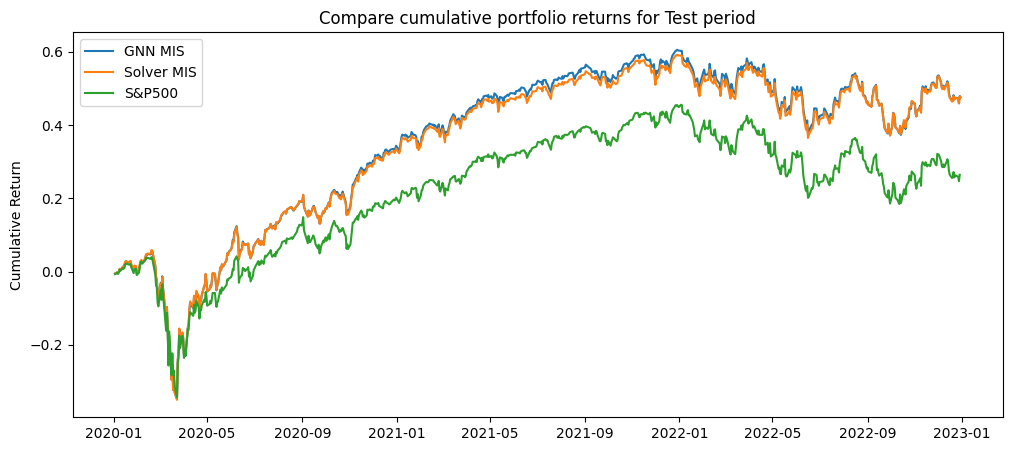

In [ ]:
# GNN MIS Portfolio
gnn_mis_returns_test, gnn_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_test, solver_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_test = gspc_test.pct_change()
gspc_returns_cum_test = gspc_returns_test.cumsum()

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_test, label="GNN MIS")
plt.plot(solver_mis_returns_cum_test, label="Solver MIS")
plt.plot(gspc_returns_cum_test, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

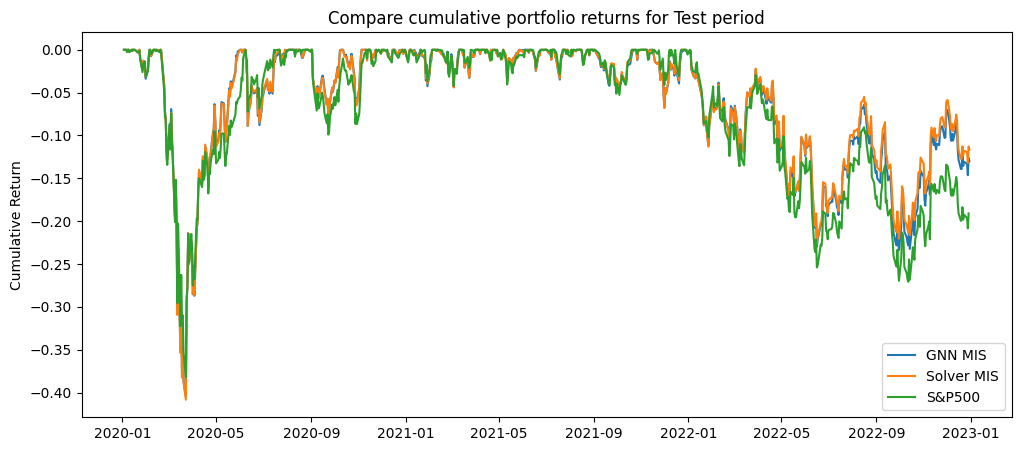

In [ ]:
gnn_mis_mdd_test = drawdown_pct(gnn_mis_returns_cum_test)
solver_mis_mdd_test = drawdown_pct(solver_mis_returns_cum_test)
gspc_mdd_test = drawdown_pct(gspc_returns_cum_test)

# gnn_mis_mdd_val = drawdown(gnn_mis_returns_cum_val)
# solver_mis_mdd_val = drawdown(solver_mis_returns_cum_val)
# gspc_mdd_val = drawdown(gspc_returns_cum_val)


# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_test, label="GNN MIS")
plt.plot(solver_mis_mdd_test, label="Solver MIS")
plt.plot(gspc_mdd_test, label="S&P500")
# plt.hlines(0, xmin=gnn_mis_mdd_test.index[0], xmax=gnn_mis_mdd_test.index[-1])
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [ ]:
# Sharpe Ratio
gnn_mis_sharpe_ratio = sharpe_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_sharpe_ratio = sharpe_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_sharpe_ratio = sharpe_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS sharpe ratio: {gnn_mis_sharpe_ratio:.2f}")
print(f"Solver MIS sharpe ratio: {solver_mis_sharpe_ratio:.2f}")
print(f"S&P500 sharpe ratio: {gspc_sharpe_ratio:.2f}\n")

# Sortino Ratio
gnn_mis_sortino_ratio = sortino_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_sortino_ratio = sortino_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_sortino_ratio = sortino_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS sortino ratio: {gnn_mis_sortino_ratio:.2f}")
print(f"Solver MIS sortino ratio: {solver_mis_sortino_ratio:.2f}")
print(f"S&P500 sortino ratio: {gspc_sortino_ratio:.2f}\n")

# Maximal drawdown
gnn_mis_mdd = max_drawdown(return_series=gnn_mis_returns_test)
solver_mis_mdd = max_drawdown(return_series=solver_mis_returns_test)
gspc_mdd = max_drawdown(return_series=gspc_returns_test)

print(f"GNN MIS MDD: {gnn_mis_mdd:.2f}")
print(f"Solver MIS MDD: {solver_mis_mdd:.2f}")
print(f"S&P500 MDD: {gspc_mdd:.2f}\n")

# Calmar ratio
gnn_mis_calmar_ratio = calmar_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_calmar_ratio = calmar_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_calmar_ratio = calmar_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS calmar ratio: {gnn_mis_calmar_ratio:.2f}")
print(f"Solver MIS calmar ratio: {solver_mis_calmar_ratio:.2f}")
print(f"S&P500 calmar ratio: {gspc_calmar_ratio:.2f}")


GNN MIS sharpe ratio: 0.58
Solver MIS sharpe ratio: 0.58
S&P500 sharpe ratio: 0.31

GNN MIS sortino ratio: 0.71
Solver MIS sortino ratio: 0.71
S&P500 sortino ratio: 0.38

GNN MIS MDD: -0.35
Solver MIS MDD: -0.35
S&P500 MDD: -0.34

GNN MIS calmar ratio: -0.42
Solver MIS calmar ratio: -0.42
S&P500 calmar ratio: -0.23
